In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import Lars, orthogonal_mp
from sklearn.decomposition import sparse_encode

sns.set_style('whitegrid')


\begin{alignat}{5}
         & \arg\!\min_{\mathcal{D}, \mathcal{R}} \|X \ -&\mathcal{D}\mathcal{R}\|_F^2  + &\lambda \sum_{i=1}^k  \|\ r_i\|_0     \quad   \\
         &\text{s.t.}  \quad  &\|d_j\|_2 \leq 1&, \forall j=1, ...,n  \quad 
\end{alignat}

$$\|X \ -\mathcal{D}\mathcal{R}\|_F^2 = \|X - D_S D_S^+ X\|_F^2$$

In [6]:
# random matrix (can be later an image for denoising!)
d = 20
K = 35
n = 27
num_steps = 30

X = np.random.uniform(low=-10, high=10, size=(d, K))
D = np.random.uniform(low=-10, high=10, size=(d, n))

# R will be n x K

# normalize D s.t. that columns of D have l2 norm = 1
for j in range(n):
    D[:, j] /= np.sum(D[:, j])

## Method of optimal directions
I found this discussion of the algorithm especially useful http://media.aau.dk/null_space_pursuits/2012/04/dictionary-learning-with-the-method-of-optimal-directions.html

In [7]:
# Method of Optimal Directions
num_nonzero = 5
cur_dict = np.copy(D)

mod_trace = []

# Take number of steps to refine dictionary 
for ii in range(num_steps):

    # Learn initial sparse representation via Lars
    clf = Lars(n_nonzero_coefs=num_nonzero)
    clf.fit(cur_dict,X)
    cur_R = clf.coef_
    
    # Calculate SVD of R and create the reciprocal Sigma matrix
    U,s,V = np.linalg.svd(cur_R.T)
    Sigma = np.zeros((U.shape[0],V.shape[0]))
    Sigma[:U.shape[0],:U.shape[0]] = np.diag(s)
    for jj in range(len(s)): 
        if Sigma[jj,jj] != 0: 
            Sigma[jj,jj] = 1./Sigma[jj,jj]
    
    # Update dictionary using singular vectors and reciprocal of singular values
    cur_dict = np.dot(np.dot(X,V.T),np.dot(Sigma.T,U.T))
    # Normalize the dictionary
    for kk in range(cur_dict.shape[1]): cur_dict[:, kk] /= np.sum(cur_dict[:, kk])

    # Calculate Frobenius norm of the estimate
    obj_val = np.linalg.norm(X-np.dot(cur_dict,cur_R.T))
    mod_trace.append(obj_val)

## Online Dictionary Learning

In [8]:
# Online Dictionary Learning from Mairal et al. (2009)

# Iteratively update Dictionary and sparse representation in two separate stages
max_iters = 2
online_trace = []
cur_dict = np.copy(D)

A = np.zeros((D.shape[1],D.shape[1]))
B = np.zeros_like(D)

for step in range(num_steps):

    
    # Run LARS to get sparse representation with current dictionary
    clf = Lars(n_nonzero_coefs=4) # Enforcing some sparsity...
    clf.fit(cur_dict,X)
    cur_R = clf.coef_ # The rows of this coefficient matrix are the alphas from Alg 1, they're associated with the columns of X
    
    # Update temporary "past" information matrices A and B
    for ii in range(cur_R.shape[0]):
        temp_alph = cur_R[ii,:].reshape(1,-1)
        temp_x    = X[:,ii].reshape(-1,1)
        A += temp_alph*temp_alph.T
        B += temp_x * temp_alph

    find_dict = True
    counter = 0
    
    # Compute the next dictionary according the ALG 2
    while find_dict & (counter < max_iters):
        counter += 1
        new_dict = np.zeros_like(cur_dict)
        for j in range(cur_dict.shape[1]):
            
            temp_uj = (np.add(np.subtract(B[:,j],cur_dict.dot(A[:,j])),cur_dict[:,j]))/(A[j,j]*1.0)
            new_dict[:,j] = temp_uj/(max(np.linalg.norm(temp_uj),1.0))
        
        if np.linalg.norm(np.subtract(cur_dict,new_dict)) < 1e-8:
            find_dict = False
        
        cur_dict = np.copy(new_dict)
    
    # Normalize the dictionary
    for k in range(cur_dict.shape[1]):
        cur_dict[:, k] /= np.sum(cur_dict[:, k])
    
    # Calculate the fit of our sparse representation and dictionary to the data
    obj_val = np.linalg.norm(X-np.dot(cur_dict,cur_R.T))
    online_trace.append(obj_val)

In [9]:
# greedy algorithm

S = np.zeros(num_steps, dtype=int)
val_trace = []
for step in range(num_steps):
    
    cur_sel_columns = list(S[:step])
    # find argmin
    norms = np.zeros(D.shape[1]) + 9999.9
    for i in range(D.shape[1]):
        if i in cur_sel_columns:
            continue
        DS = D[:, cur_sel_columns+[i]]
        
        norms[i] = np.linalg.norm(X - np.dot(DS, np.dot(np.linalg.pinv(DS), X)), 'fro')
    S[step] = np.argmin(norms)
    
    # add current norm value for the current dict
    cur_sel_columns = list(S[:step+1])
    DS = D[:, cur_sel_columns]
    obj_val = np.linalg.norm(X - np.dot(DS, np.dot(np.linalg.pinv(DS), X)), 'fro')
    val_trace.append(obj_val)
    print(cur_sel_columns)

[21]
[21, 24]
[21, 24, 17]
[21, 24, 17, 6]
[21, 24, 17, 6, 22]
[21, 24, 17, 6, 22, 25]
[21, 24, 17, 6, 22, 25, 19]
[21, 24, 17, 6, 22, 25, 19, 26]
[21, 24, 17, 6, 22, 25, 19, 26, 14]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12, 8]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12, 8, 0]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12, 8, 0, 5]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12, 8, 0, 5, 9]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12, 8, 0, 5, 9, 4]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12, 8, 0, 5, 9, 4, 20]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12, 8, 0, 5, 9, 4, 20, 11]
[21, 24, 17, 6, 22, 25, 19, 26, 14, 15, 13, 23, 10, 12, 8, 0, 5, 9, 4, 20, 11, 1]
[21, 24, 17, 6, 

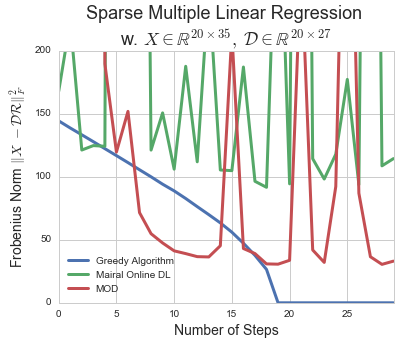

In [10]:
plt.figure()
plt.plot(val_trace,lw=3,label='Greedy Algorithm')
plt.plot(online_trace,lw=3,label='Mairal Online DL')
plt.plot(mod_trace,lw=3,label='MOD')
plt.title('Sparse Multiple Linear Regression \nw. $X \in \mathbb{R}^{20 \\times 35},\\; \mathcal{D} \in \mathbb{R}^{20 \\times 27}$',fontsize=18)
plt.ylabel('Frobenius Norm $\|X \ -\mathcal{D}\mathcal{R}\|_F^2$',fontsize=14)
plt.xlabel('Number of Steps',fontsize=14)
plt.xlim(0, len(val_trace)-1)
plt.ylim(0,200)
plt.legend(loc='best')
plt.subplots_adjust(top=1)
plt.savefig('sparse_MLR_greedy_online.png', dpi=120)
plt.show()
